In [1]:
import SimpleITK as sitk
import numpy as np
from pymskt.image.meniscus_processing import subdivide_meniscus_regions
import matplotlib.pyplot as plt


In [2]:
path_seg = '/dataNAS/people/aagatti/projects/connie_ashley/dependencies/pymskt/data/SAG_3D_DESS_RIGHT_bones_cart_men_fib-label.nrrd'
seg_image = sitk.ReadImage(path_seg)

MED_MENISCUS_LABEL = 10
LAT_MENISCUS_LABEL = 9
MED_TIB_CART_LABEL = 2
LAT_TIB_CART_LABEL = 3
TIB_LABEL = 6
PAT_LABEL = 7
PAT_CART_LABEL = 4

Starting meniscus sub-region division...
Verifying and correcting meniscus sides using method: tibial_centroid...
Medial Tibial Cartilage Centroid (ML-axis): 63.07
Lateral Tibial Cartilage Centroid (ML-axis): 111.39
Using Tibial Bone Centroid Split Point: 90
Applying plane split at axis 0 = 90
Using spacing: ML=0.7000 (axis 0), AP=0.3646 (axis 2)
Defining polar coordinate system center using method: cartilage...
Tibial Centroid (ML, AP): (90.18, 207.55)
Using individual tibial cartilage centroids as polar centers.
Medial Cartilage Center (ML, AP): (63.07, 208.67)
Lateral Cartilage Center (ML, AP): (111.39, 229.82)
Adjusting cartilage centers inward by fraction: 0.25
Adjusted Medial Center (ML, AP): (75.15, 213.96)
Adjusted Lateral Center (ML, AP): (99.31, 224.53)
Using patella centroid to define Anterior direction.
Using patella bone label 7 for anchor.
Patellar Anchor Centroid (ML, AP): (97.79, 78.32)
Anterior Reference Angle (Patella direction = 0 degrees): -86.63 degrees relative to

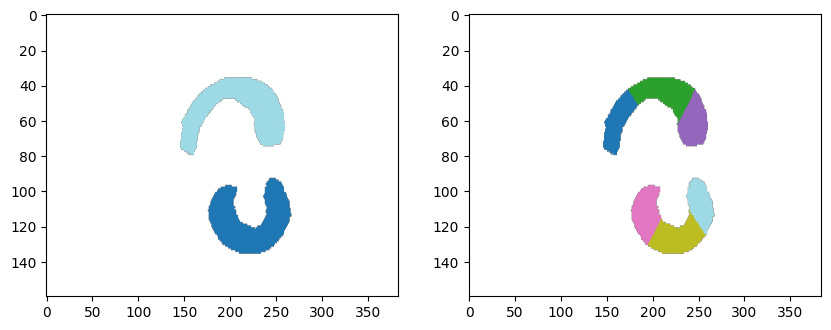

In [6]:


updated_seg_image = subdivide_meniscus_regions(
    seg_image,
    med_meniscus_label=MED_MENISCUS_LABEL, # Example label
    lat_meniscus_label=LAT_MENISCUS_LABEL, # Example label
    med_tib_cart_label=MED_TIB_CART_LABEL,
    lat_tib_cart_label=LAT_TIB_CART_LABEL,
    tib_label=TIB_LABEL, # Default tibial bone label
    pat_label=PAT_LABEL, # Optional: Label for Patella bone
    pat_cart_label=PAT_CART_LABEL, # Optional: Label for Patellar Cartilage
    ml_axis=0,
    ap_axis=2, # Assuming AP is axis 2 for angle calculation
    is_axis=1, # Assuming IS is axis 1
    min_cart_voxels=100, # Min voxels for tibial cartilage to be considered valid
    cleanup_method='tibial_centroid', # Method passed to verify_and_correct_meniscus_sides
    center_method='cartilage', # Center for polar coords: 'tibia' or 'cartilage'
    label_map = None, # Optional dict to override default subregion labels
    verbose=True,
    cartilage_center_offset_fraction = 0.25
)


seg_array = sitk.GetArrayFromImage(seg_image)
updated_seg_array = sitk.GetArrayFromImage(updated_seg_image)

# get a volume of only the meniscus labels
meniscus_labels = [MED_MENISCUS_LABEL, LAT_MENISCUS_LABEL]
meniscus_volume = np.zeros_like(seg_array)
for label in meniscus_labels:
    meniscus_volume[seg_array == label] = label

meniscus_labels_updated = [101, 102, 103, 104, 105, 106]
meniscus_volume_updated = np.zeros_like(updated_seg_array)
for label in meniscus_labels_updated:
    meniscus_volume_updated[updated_seg_array == label] = label-100


# plot the flattned versions of the two meniscus volumes. Flatten along
# the inferior-superior axis

IS_AXIS = 1

flat_meniscus_volume = np.max(meniscus_volume, axis=IS_AXIS).astype(float)
flat_meniscus_volume_updated = np.max(meniscus_volume_updated, axis=IS_AXIS).astype(float)

print(np.unique(flat_meniscus_volume))
print(np.unique(flat_meniscus_volume_updated))

aspect_ratio = seg_image.GetSpacing()[2] / seg_image.GetSpacing()[1]

flat_meniscus_volume[flat_meniscus_volume == 0] = np.nan
flat_meniscus_volume_updated[flat_meniscus_volume_updated == 0] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(flat_meniscus_volume, cmap='tab20', aspect=aspect_ratio)
axs[1].imshow(flat_meniscus_volume_updated, cmap='tab20', aspect=aspect_ratio)


In [24]:
# create 3d models of the tibia, cartilage, and menisci
from pymskt.mesh import BoneMesh, CartilageMesh

tibia_mesh = BoneMesh(seg_image=seg_image, label_idx=TIB_LABEL)
med_meniscus_mesh = BoneMesh(seg_image=seg_image, label_idx=MED_MENISCUS_LABEL)
lat_meniscus_mesh = BoneMesh(seg_image=seg_image, label_idx=LAT_MENISCUS_LABEL)

tibia_mesh.create_mesh(smooth_image_var=0.7)
tibia_mesh.resample_surface(clusters=10_000)
tibia_mesh.compute_normals()

med_meniscus_mesh.create_mesh(smooth_image_var=0.7)
med_meniscus_mesh.resample_surface(clusters=3_000)
med_meniscus_mesh.compute_normals()

lat_meniscus_mesh.create_mesh(smooth_image_var=0.6)
lat_meniscus_mesh.resample_surface(clusters=3_000)
lat_meniscus_mesh.compute_normals()

med_meniscus_mesh.seg_image = updated_seg_image
lat_meniscus_mesh.seg_image = updated_seg_image

med_meniscus_mesh_ = CartilageMesh(med_meniscus_mesh)
lat_meniscus_mesh_ = CartilageMesh(lat_meniscus_mesh)

med_meniscus_mesh.list_cartilage_meshes = [med_meniscus_mesh_]
lat_meniscus_mesh.list_cartilage_meshes = [lat_meniscus_mesh_]

med_meniscus_mesh.assign_cartilage_regions(ray_cast_length=-1, percent_ray_length_opposite_direction=0, n_intersections=1)
lat_meniscus_mesh.assign_cartilage_regions(ray_cast_length=-1, percent_ray_length_opposite_direction=0, n_intersections=1)


INTERSECTION IS:  1
INTERSECTION IS:  1


In [28]:
array = sitk.GetArrayFromImage(updated_seg_image)
np.unique(array)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 101, 102, 103, 104,
       105, 106], dtype=uint8)

In [29]:
med_tib_cart_mesh = CartilageMesh(seg_image=updated_seg_image, label_idx=MED_TIB_CART_LABEL)
lat_tib_cart_mesh = CartilageMesh(seg_image=updated_seg_image, label_idx=LAT_TIB_CART_LABEL)

med_tib_cart_mesh.create_mesh(smooth_image_var=0.7)
med_tib_cart_mesh.resample_surface(clusters=3_000)
med_tib_cart_mesh.compute_normals()

lat_tib_cart_mesh.create_mesh(smooth_image_var=0.7)
lat_tib_cart_mesh.resample_surface(clusters=3_000)
lat_tib_cart_mesh.compute_normals()

med_tib_cart_mesh.save_mesh('med_tib_cart_mesh.vtk')
lat_tib_cart_mesh.save_mesh('lat_tib_cart_mesh.vtk')


In [12]:
from itkwidgets import view

In [30]:
view(geometries=[tibia_mesh, med_meniscus_mesh, lat_meniscus_mesh, med_tib_cart_mesh, lat_tib_cart_mesh])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [27]:
med_meniscus_mesh.save_mesh('med_meniscus_mesh.vtk')
lat_meniscus_mesh.save_mesh('lat_meniscus_mesh.vtk')
tibia_mesh.save_mesh('tibia_mesh.vtk')
